# DATA512 - Homework 1: Professionalism and Reproducibility

## Academy Award Winning Articles Monthly Traffic Analysis

### Tanushree Yandra, University of Washington, Seattle

The aim of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for articles about academy award winning movies from English Wikipedia from July 1, 2015 through September 30, 2023. This report documents the data acquisition, data preprocessing and data analysis processes in detail with relevant plots and code snippets attached. It explores some common patterns and trends in the pageviews of academy award winning movies across desktop and mobile access types as a time series analysis.

## 1. Data Acquisition

The first step of the study is to collect the data from the Pageviews API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) to measure article traffic from 2015-2023. The Pageviews API provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month. The pageviews counts are collected using a specified subset of Wikipedia article pages that represent a large number of [articles about academy award winning movies](https://docs.google.com/spreadsheets/d/1A1h_7KAo7KXaVxdScJmIVPTvjb3IuY9oZhNV4ZHxrxw/edit?usp=sharing). The data retrieved is then used to create three related datasets, all of which are time series of monthly activity.

The Wikimedia Rest API was used to request monthly counts of page views for the articles. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand the process.

The code below has been sampled from [this sample notebook](https://drive.google.com/file/d/1XjFhd3eXx704tcdfQ4Q1OQn0LWKCRNJm/view?usp=sharing) that contains sample code to make the Pageviews Wikipedia API call.

In [1]:
# These are standard python modules
import json, time, urllib.parse
import pandas as pd
import warnings

# The modules below are not standard Python modules
# You will need to install these with pip/pip3 if you do not already have it
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

In [2]:
# Suppress the warning statements
warnings.filterwarnings("ignore")

Some constants have been defined below to make the code more readable.

In [3]:
# The REST API 'pageviews' URL is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'


# This is a parameterized string that helps specify what kind of 'pageviews' request is being made
# In this case, it will be a 'per-article' based request
# The string is a format string so that each parameter can be replaced with an appropriate value
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second
# Assuming a small delay of roughly 2ms to each request
API_LATENCY_ASSUMED = 0.002
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API, including your email address will allow them to contact you if
# some error occurs - such as - your code exceeding rate limits
REQUEST_HEADERS = {
    'User-Agent': '<tyandra@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This template is used to map parameter values to the API_REQUST_PER_ARTICLE_PARAMS portion of the API request
# The below dictionary has a field/key for each of the required parameters
# Only the 'article' and 'access' variable are varied for this study keeping all the other parameters constant
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",             # this will be set to desktop/mobile-web/mobile-app based on access type
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start date is set to 1st July, 2015
    "end":         "2023093000"    # end date is set to 30th September, 2023
}


The list of article titles have been extracted from a collection of articles about academy award winning movies.

In [4]:
# Extract the article names from the csv about academy award winning movies, and convert to a list
movie_titles_df = pd.read_csv('thank_the_academy.AUG.2023.csv')
articles_list = movie_titles_df['name'].tolist()
# Sort the articles alphabetically
ARTICLE_TITLES = sorted(articles_list)

The API request will be made using the below procedure. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore, the parameter most likely to change is the article_title.

In [5]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # Article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Article titles are encoded to have spaces replaced with "_" in the URL
    # The 'safe' parameter ensures that the special character '\' is encoded and not ignored in the URL
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe="")
    request_template['article'] = article_title_encoded
    
    # Create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # Make the request
    try:
        # Wait first, to make sure we don't exceed the limit in case an exception occurs while requesting
        # Throttling is always a good practice with a free data source like Wikipedia
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Now that the necessary parameters and functions have been defined, the next task is to make the API calls and generate the datasets. Three datasets are created based on the access types - mobile, desktop, and both. These datasets are saved as JSON files ordered using article titles as a key, with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files. The three datasets are mentioned below in more detail,

### (a) Mobile Access

The API separates mobile access types into two separate requests - mobile-web, and mobile-app. The total views of both these types is evaluated to make one count for all mobile pageviews.

In [6]:
# Initiate an empty list
mobile_access = []

# Iterate through all the articles and make an API call
for article_title in ARTICLE_TITLES:
    # Set the access to 'mobile-web' and 'mobile-app' before generating the request
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-web'
    mobile_web_article = request_pageviews_per_article(article_title)
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-app'
    mobile_app_article = request_pageviews_per_article(article_title)
    
    try:
        # Key to be removed
        remove_field = 'access'

        # Remove the access key from all dictionaries in both the responses
        mobile_web = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_web_article['items']]
        mobile_app = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_app_article['items']]

        # Iterate through the individual monthly data and add the monthly views for both web and app access
        for web_entry, app_entry in zip(mobile_web, mobile_app):
            web_entry['views'] = web_entry['views'] + app_entry['views']

        # Initiate a new nested dictionary
        nested_dict = {}
        
        for item in mobile_web:
            # Get the value of the "article" key
            article_key = item["article"]
    
            # Remove the "article" key from the dictionary
            del item["article"]
    
            # Create a nested dictionary using the "article" value as the key
            if article_key not in nested_dict:
                nested_dict[article_key] = []
    
            # Append the remaining dictionary (without the "article" key) to the nested dictionary
            nested_dict[article_key].append(item)
        
        # Append the article-level object to the list which will later be saved as a JSON object
        mobile_access.append(nested_dict)

    except:
        pass

In [7]:
# Check the total elements in the data, the total should be 1359
len(mobile_access)

1359

Now that the mobile access data has been generated, the next step is to convert it into a json file. The json file is exported to the local system with the file name 'academy_monthly_mobile_start201507-end202309.json'. This final output file is a list of dictionaries where each dictionary has the article name as the key. The values for this dictionary are once again a list of dictionaries with five key-value pairs - 'project', 'granularity', 'timestamp', 'agent', and 'views'. Except for 'views' which has integer values, all the other keys have string values.

In [8]:
mobile_json = json.dumps(mobile_access, indent=4)

with open("academy_monthly_mobile_start201507-end202309.json", "w") as outfile:
    outfile.write(mobile_json)

### (b) Desktop Access

Monthly desktop page traffic is based on one single request, and the API request is made by setting the access type to 'desktop'.

In [9]:
# Set the access type to 'desktop'
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'desktop'
# Initiate an empty list
desktop_access = []

# Iterate through all the articles and make an API call
for article_title in ARTICLE_TITLES:
    desktop_article = request_pageviews_per_article(article_title)
    try:
        # Key to be removed
        remove_field = 'access'

        # Remove the access key from all dictionaries
        dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in desktop_article['items']]
        
        # Initiate a new nested dictionary
        nested_dict = {}
        
        for item in dicts_list:
            # Get the value of the "article" key
            article_key = item["article"]
    
            # Remove the "article" key from the dictionary
            del item["article"]
    
            # Create a nested dictionary using the "article" value as the key
            if article_key not in nested_dict:
                nested_dict[article_key] = []
    
            # Append the remaining dictionary (without the "article" key) to the nested dictionary
            nested_dict[article_key].append(item)
        
        # Append the article-level object to the list which will later be saved as a JSON object
        desktop_access.append(nested_dict)
    except:
        pass

In [10]:
# Check the total elements in the data, the total should be 1359
len(desktop_access)

1359

The next step is to convert the generated data to a json file. The json file is exported to the local system with the file name 'academy_monthly_desktop_start201507-end202309.json'. This final output file like the previous output file, is a list of dictionaries where each dictionary has the article name as the key. The values for this dictionary are once again a list of dictionaries with five key-value pairs - 'project', 'granularity', 'timestamp', 'agent', and 'views'. Except for 'views' which has integer values, all the other keys have string values.

In [11]:
desktop_json = json.dumps(desktop_access, indent=4)

with open("academy_monthly_desktop_start201507-end202309.json", "w") as outfile:
    outfile.write(desktop_json)

### (c) Cumulative Access

Monthly cumulative data is the sum of all mobile, and all desktop traffic per article per month. The code to create this file is given below,

In [12]:
# Initiate an empty list
cumulative_access = []

# Iterate through the mobile and desktop access list of dictionaries by month
for mobile_entry, desktop_entry in zip(mobile_access, desktop_access):
    # Extract the article name from the mobile views dictionary
    article = list(mobile_entry.keys())[0]
    
    # Initiate an empty dictionary
    cumulative_entry = {}
    # Set the key as the article name with the value as the empty list
    cumulative_entry[article] = []
    
    # Iterate through the monthly data for the article across mobile and desktop data
    for sub_mobile_entry, sub_desktop_entry in zip(mobile_entry[article], desktop_entry[article]):
        # Create a copy of the mobile dictionary
        sub_cumulative_entry = sub_mobile_entry.copy()
        
        # Find the cumulative views
        sub_cumulative_entry['views'] = sub_mobile_entry['views'] + sub_desktop_entry['views']
        
        #Append the updated entry into the nested dictionary
        cumulative_entry[article].append(sub_cumulative_entry)
    
    # Append the nested dicitonary to the final data
    cumulative_access.append(cumulative_entry)

In [13]:
# Check the total elements in the data, the total should be 1359
len(cumulative_access)

1359

The next step is to convert the cumulative data into a json file. Once again, the json file is exported to the local system with the file name 'academy_monthly_cumulative_start201507-end202309.json'. This final output file like the previous output files, is a list of dictionaries where each dictionary has the article name as the key. The values for this dictionary are a list of dictionaries with five key-value pairs - 'project', 'granularity', 'timestamp', 'agent', and 'views'. Except for 'views' which has integer values, all the other keys have string values.

In [14]:
cumulative_json = json.dumps(cumulative_access, indent=4)

with open("academy_monthly_cumulative_start201507-end202309.json", "w") as outfile:
    outfile.write(cumulative_json)

## 2. Data Preprocessing

Before moving to the data analysis, it is important to check the data for any irregularities, and preprocess it. While the data can be accessed by using the 'mobile_access' and 'desktop_access' lists of dictionaries created earlier, the below code shows how to access the data from the JSON files that we just exported.

In [6]:
# Load the JSON data as a list of dictionaries
with open('academy_monthly_mobile_start201507-end202309.json') as f:
    mobile_data = json.load(f)

In [7]:
# Create an empty list to store the data
flat_mobile_data = []

# Iterate through the list of dictionaries
for item in mobile_data:
    for key, value in item.items():
        article = key
        for entry in value:
            # Add the 'article' column
            entry["article"] = article 
            flat_mobile_data.append(entry)

# Create a DataFrame from the flattened data
mobile_df = pd.DataFrame(flat_mobile_data)

In [8]:
mobile_df

,project,granularity,timestamp,agent,views,article
0,en.wikipedia,monthly,2015070100,user,75458,12_Years_a_Slave_(film)
1,en.wikipedia,monthly,2015080100,user,64091,12_Years_a_Slave_(film)
2,en.wikipedia,monthly,2015090100,user,53916,12_Years_a_Slave_(film)
3,en.wikipedia,monthly,2015100100,user,61688,12_Years_a_Slave_(film)
4,en.wikipedia,monthly,2015110100,user,61671,12_Years_a_Slave_(film)
...,...,...,...,...,...,...
128954,en.wikipedia,monthly,2023050100,user,8627,Zorba_the_Greek_(film)
128955,en.wikipedia,monthly,2023060100,user,8766,Zorba_the_Greek_(film)
128956,en.wikipedia,monthly,2023070100,user,14820,Zorba_the_Greek_(film)
128957,en.wikipedia,monthly,2023080100,user,13733,Zorba_the_Greek_(film)


In [9]:
mobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128959 entries, 0 to 128958
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   project      128959 non-null  object
 1   granularity  128959 non-null  object
 2   timestamp    128959 non-null  object
 3   agent        128959 non-null  object
 4   views        128959 non-null  int64 
 5   article      128959 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.9+ MB


It can be observed that the 'timestamp' column is not of the type datetime. The steps below convert it to a datetime object. 

In [10]:
# Omit the last two digits from the timestamp which represent the hours. We only need the year, month and date.
mobile_df['timestamp'] = mobile_df['timestamp'].str[:-2]
mobile_df['timestamp'] = pd.to_datetime(mobile_df['timestamp'])

In [11]:
# Drop columns that are not relevant for analysis
mobile_df = mobile_df.drop(columns=['project','granularity','agent'], axis=1)

In [12]:
mobile_df

,timestamp,views,article
0,2015-07-01,75458,12_Years_a_Slave_(film)
1,2015-08-01,64091,12_Years_a_Slave_(film)
2,2015-09-01,53916,12_Years_a_Slave_(film)
3,2015-10-01,61688,12_Years_a_Slave_(film)
4,2015-11-01,61671,12_Years_a_Slave_(film)
...,...,...,...
128954,2023-05-01,8627,Zorba_the_Greek_(film)
128955,2023-06-01,8766,Zorba_the_Greek_(film)
128956,2023-07-01,14820,Zorba_the_Greek_(film)
128957,2023-08-01,13733,Zorba_the_Greek_(film)


Repeat the above process for desktop access data.

In [13]:
# Load the JSON data as a list of dictionaries
with open('academy_monthly_desktop_start201507-end202309.json') as f:
    desktop_data = json.load(f)

In [14]:
# Create an empty list to store the data
flat_desktop_data = []

# Iterate through the list of dictionaries
for item in desktop_data:
    for key, value in item.items():
        article = key
        for entry in value:
            # Add the 'article' column
            entry["article"] = article 
            flat_desktop_data.append(entry)

# Create a DataFrame from the flattened data
desktop_df = pd.DataFrame(flat_desktop_data)

In [15]:
desktop_df

,project,granularity,timestamp,agent,views,article
0,en.wikipedia,monthly,2015070100,user,62693,12_Years_a_Slave_(film)
1,en.wikipedia,monthly,2015080100,user,58902,12_Years_a_Slave_(film)
2,en.wikipedia,monthly,2015090100,user,59116,12_Years_a_Slave_(film)
3,en.wikipedia,monthly,2015100100,user,65535,12_Years_a_Slave_(film)
4,en.wikipedia,monthly,2015110100,user,66646,12_Years_a_Slave_(film)
...,...,...,...,...,...,...
128954,en.wikipedia,monthly,2023050100,user,4398,Zorba_the_Greek_(film)
128955,en.wikipedia,monthly,2023060100,user,3865,Zorba_the_Greek_(film)
128956,en.wikipedia,monthly,2023070100,user,5919,Zorba_the_Greek_(film)
128957,en.wikipedia,monthly,2023080100,user,5789,Zorba_the_Greek_(film)


In [16]:
desktop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128959 entries, 0 to 128958
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   project      128959 non-null  object
 1   granularity  128959 non-null  object
 2   timestamp    128959 non-null  object
 3   agent        128959 non-null  object
 4   views        128959 non-null  int64 
 5   article      128959 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.9+ MB


The above dataframe does not have the 'timestamp' column as a datetime object.

In [17]:
# Omit the last two digits from the timestamp which represent the hours. We only need the year, month and date.
desktop_df['timestamp'] = desktop_df['timestamp'].str[:-2]
desktop_df['timestamp'] = pd.to_datetime(desktop_df['timestamp'])

In [18]:
# Drop columns that are not relevant for analysis
desktop_df = desktop_df.drop(columns=['project','granularity','agent'], axis=1)

In [19]:
desktop_df

,timestamp,views,article
0,2015-07-01,62693,12_Years_a_Slave_(film)
1,2015-08-01,58902,12_Years_a_Slave_(film)
2,2015-09-01,59116,12_Years_a_Slave_(film)
3,2015-10-01,65535,12_Years_a_Slave_(film)
4,2015-11-01,66646,12_Years_a_Slave_(film)
...,...,...,...
128954,2023-05-01,4398,Zorba_the_Greek_(film)
128955,2023-06-01,3865,Zorba_the_Greek_(film)
128956,2023-07-01,5919,Zorba_the_Greek_(film)
128957,2023-08-01,5789,Zorba_the_Greek_(film)


## 3. Data Analysis

With the data all clean and preprocessed, we can move on to the analysis. The aim of the analysis is to graph specific subsets of the data as a timeseries. The timeseries graphs have been built which are explained in the next sections.

### (a) Maximum Average and Minimum Average

This graph plots the time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access.

In [20]:
# Group the desktop access data by article and find the average monthly views for each article
desktop_results = desktop_df.groupby('article')['views'].mean().reset_index()
# Sort the results
desktop_results_sorted = desktop_results.sort_values(by='views', ascending=False).reset_index(drop=True)
desktop_results_sorted

,article,views
0,Joker_(2019_film),216853.253968
1,Dune_(2021_film),211723.805556
2,The_Whale_(2022_film),195752.933333
3,Parasite_(2019_film),192253.962963
4,Tenet_(film),173127.283019
...,...,...
1354,Aquatic_House_Party,42.525253
1355,Who's_Who_in_Animal_Land,42.353535
1356,Princeton:_A_Search_for_Answers,42.111111
1357,Facing_Your_Danger,41.696970


In [21]:
# Select the first and last row of the sorted dataframe to get the highest and lowest average views
n = desktop_results_sorted.shape[0]
desktop_highest = desktop_results_sorted['article'][0]
desktop_lowest = desktop_results_sorted['article'][n-1]

Repeat the above process with mobile access data too.

In [22]:
# Group the mobile access data by article and find the average monthly views for each article
mobile_results = mobile_df.groupby('article')['views'].mean().reset_index()
# Sort the results
mobile_results_sorted = mobile_results.sort_values(by='views', ascending=False).reset_index(drop=True)
mobile_results_sorted

,article,views
0,The_Whale_(2022_film),525412.866667
1,Black_Panther:_Wakanda_Forever,449154.034483
2,Joker_(2019_film),428758.158730
3,Dune_(2021_film),427554.222222
4,RRR_(film),377642.172414
...,...,...
1354,Of_Pups_and_Puzzles,12.474747
1355,Busy_Little_Bears,11.585859
1356,Aquatic_House_Party,10.424242
1357,Casals_Conducts:_1964,10.262626


In [23]:
# Select the first and last row of the sorted dataframe to get the highest and lowest average views
m = mobile_results_sorted.shape[0]
mobile_highest = mobile_results_sorted['article'][0]
mobile_lowest = mobile_results_sorted['article'][m-1]

In [24]:
# Extract the corresponding monthly data of the four articles from desktop and mobile access dataframes
desktop_highest_ts = desktop_df[desktop_df['article']==desktop_highest]
desktop_lowest_ts = desktop_df[desktop_df['article']==desktop_lowest]
mobile_highest_ts = mobile_df[mobile_df['article']==mobile_highest]
mobile_lowest_ts = mobile_df[mobile_df['article']==mobile_lowest]

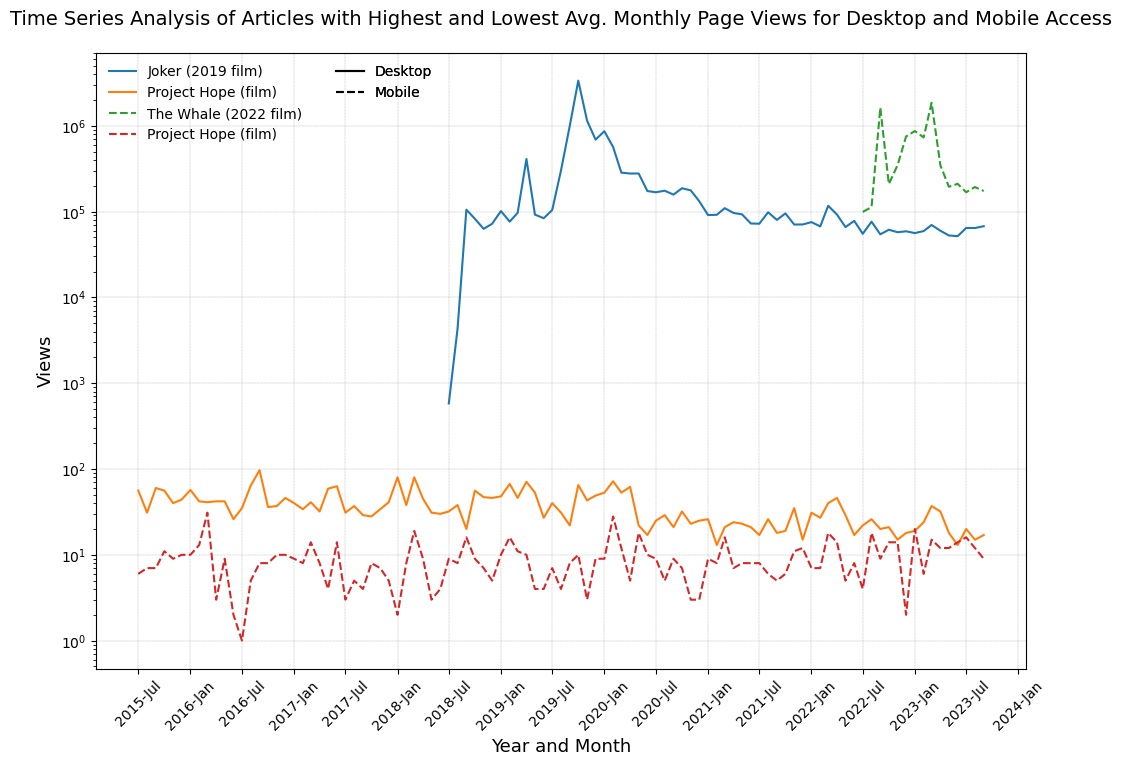

In [25]:
# Plot the views as a timeseries graph for the four articles
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(desktop_highest_ts['timestamp'], desktop_highest_ts['views'], linestyle='-',
        label=desktop_highest.replace('_',' '))
ax.plot(desktop_lowest_ts['timestamp'], desktop_lowest_ts['views'], linestyle='-',
        label=desktop_lowest.replace('_',' '))
ax.plot(mobile_highest_ts['timestamp'], mobile_highest_ts['views'], linestyle='--',
        label=mobile_highest.replace('_',' '))
ax.plot(mobile_lowest_ts['timestamp'], mobile_lowest_ts['views'], linestyle='--',
        label=mobile_lowest.replace('_',' '))

# Set the x-axis ticks to show every sixth month in the data
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,6)))
# Change the format of the x-axix label (prior to this it is 'YYYY-MM') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

# Set axes labels and title with appropriate font size
plt.xlabel('Year and Month', fontsize=13)
plt.ylabel('Views', fontsize=13)
plt.title('Time Series Analysis of Articles with Highest and Lowest Avg. Monthly Page Views for Desktop and \
Mobile Access', pad=20, fontsize=14)

# Since the highest and lowest views largely vary in scale, use logarithmic axis to better portray the data
ax.set_yscale('log')

# The first legend below represents all the article names
legend1 = plt.legend(frameon=False)
ax.add_artist(legend1)

# The second legend groups the titles based on the two access types - desktop and mobile
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend2 = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.375, 1), frameon=False)
ax.add_artist(legend2)

# Add gridlines
plt.grid(True, linestyle='--', color='gray', linewidth=0.2)

plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()

It is found that the 'Joker (2019)' and 'The Whale (2022)' movies have the highest monthly average views for desktop and mobile access respectively. While 'The Whale' movie is much more recent and follows a shorter path of time with a few peaks present, the 'Joker' movie follows a longer path with one large peak. The 'Project Hope' movie on the other hand, has the lowest monthly average views for both desktop and mobile access. It's path fluctuates a lot throughout with several peaks and drops.

### (b) Top 10 Peak Page Views

The following graph contains time series data for the top 10 article pages by largest (peak) page views over the entire time by access type.

In [26]:
# Sort the desktop views in descending manner
desktop_views_sort = desktop_df.sort_values(by='views', ascending=False).reset_index(drop=True)
desktop_views_sort

,timestamp,views,article
0,2019-10-01,3355060,Joker_(2019_film)
1,2020-02-01,2813357,Parasite_(2019_film)
2,2018-02-01,2659906,Black_Panther_(film)
3,2016-01-01,2165430,The_Revenant_(2015_film)
4,2022-12-01,1890048,Avatar:_The_Way_of_Water
...,...,...,...
128954,2016-07-01,0,Tango_(1981_film)
128955,2016-05-01,0,The_Personals:_Improvisations_on_Romance_in_th...
128956,2022-06-01,0,An_Irish_Goodbye
128957,2016-08-01,0,Tango_(1981_film)


In [27]:
# Retrieve the Top 10 articles and the month for each article that contains the highest page views
desktop_top10 = desktop_views_sort[:10]
desktop_top10['peak_month'] = desktop_top10['timestamp'].apply(lambda x: x.month)
desktop_top10

,timestamp,views,article,peak_month
0,2019-10-01,3355060,Joker_(2019_film),10
1,2020-02-01,2813357,Parasite_(2019_film),2
2,2018-02-01,2659906,Black_Panther_(film),2
3,2016-01-01,2165430,The_Revenant_(2015_film),1
4,2022-12-01,1890048,Avatar:_The_Way_of_Water,12
5,2015-11-01,1812832,Spectre_(2015_film),11
6,2021-10-01,1694498,Dune_(2021_film),10
7,2020-01-01,1567798,1917_(2019_film),1
8,2020-09-01,1565634,Tenet_(film),9
9,2017-10-01,1517482,Blade_Runner_2049,10


It can be observed that all the Top-10 movies have a peak during the fall and winter months - Septemober, October, November, December, January and February.

In [28]:
# Retrieve the article names of the top 10 rows which represent the movies with largest page views
desktop_top10_articles = desktop_top10['article'].tolist()
desktop_top10_articles

['Joker_(2019_film)',
 'Parasite_(2019_film)',
 'Black_Panther_(film)',
 'The_Revenant_(2015_film)',
 'Avatar:_The_Way_of_Water',
 'Spectre_(2015_film)',
 'Dune_(2021_film)',
 '1917_(2019_film)',
 'Tenet_(film)',
 'Blade_Runner_2049']

Repeat the above process with mobile access data too.

In [29]:
# Sort the mobile views in descending manner
mobile_views_sort = mobile_df.sort_values(by='views', ascending=False).reset_index(drop=True)
mobile_views_sort

,timestamp,views,article
0,2022-12-01,8106378,Avatar:_The_Way_of_Water
1,2019-10-01,8047344,Joker_(2019_film)
2,2018-02-01,5503665,Black_Panther_(film)
3,2020-02-01,5484956,Parasite_(2019_film)
4,2023-01-01,5225051,Avatar:_The_Way_of_Water
...,...,...,...
128954,2022-02-01,0,An_Irish_Goodbye
128955,2022-03-01,0,An_Irish_Goodbye
128956,2022-04-01,0,An_Irish_Goodbye
128957,2016-10-01,0,Cruella_(film)


In [30]:
# Retrieve the Top 10 articles and the month for each article that contains the highest page views
mobile_top10 = mobile_views_sort[:10]
mobile_top10['peak_month'] = mobile_top10['timestamp'].apply(lambda x: x.month)
mobile_top10

,timestamp,views,article,peak_month
0,2022-12-01,8106378,Avatar:_The_Way_of_Water,12
1,2019-10-01,8047344,Joker_(2019_film),10
2,2018-02-01,5503665,Black_Panther_(film),2
3,2020-02-01,5484956,Parasite_(2019_film),2
4,2023-01-01,5225051,Avatar:_The_Way_of_Water,1
5,2022-11-01,4634986,Black_Panther:_Wakanda_Forever,11
6,2022-04-01,4114488,RRR_(film),4
7,2021-10-01,3956760,Dune_(2021_film),10
8,2016-01-01,3802421,The_Revenant_(2015_film),1
9,2022-06-01,3784632,Top_Gun:_Maverick,6


It can be observed that the movie 'Avatar: The Way of Water' repeats in the Top 10 list. With the assumption that the movie names have to be unique, the top 10 unique movies have been selected in the step below.

In [31]:
# Retrieve the Top 10 unique articles and the month for each article that contains the highest page views
mobile_top10 = mobile_views_sort.drop_duplicates(['article']).head(10)
mobile_top10['peak_month'] = mobile_top10['timestamp'].apply(lambda x: x.month)
mobile_top10

,timestamp,views,article,peak_month
0,2022-12-01,8106378,Avatar:_The_Way_of_Water,12
1,2019-10-01,8047344,Joker_(2019_film),10
2,2018-02-01,5503665,Black_Panther_(film),2
3,2020-02-01,5484956,Parasite_(2019_film),2
5,2022-11-01,4634986,Black_Panther:_Wakanda_Forever,11
6,2022-04-01,4114488,RRR_(film),4
7,2021-10-01,3956760,Dune_(2021_film),10
8,2016-01-01,3802421,The_Revenant_(2015_film),1
9,2022-06-01,3784632,Top_Gun:_Maverick,6
10,2023-03-01,3597067,Everything_Everywhere_All_at_Once,3


The pattern that was observed earlier in the desktop pageviews count is not as strong in the mobile access type. Although the fall and winter months are dominating, there are a few movies with the peak months in spring and summer

In [32]:
# Retrieve the article names of the top 10 unique rows which represent the movies with largest page views
mobile_top10_articles = mobile_top10['article'].tolist()
mobile_top10_articles

['Avatar:_The_Way_of_Water',
 'Joker_(2019_film)',
 'Black_Panther_(film)',
 'Parasite_(2019_film)',
 'Black_Panther:_Wakanda_Forever',
 'RRR_(film)',
 'Dune_(2021_film)',
 'The_Revenant_(2015_film)',
 'Top_Gun:_Maverick',
 'Everything_Everywhere_All_at_Once']

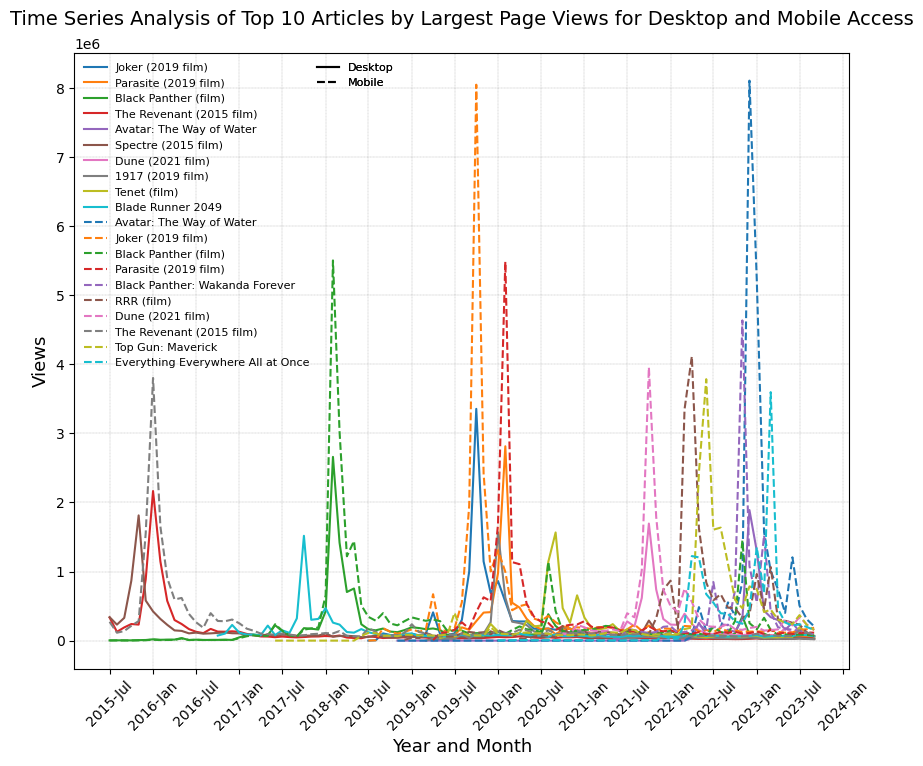

In [33]:
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Iterate through all the articles in desktop and mobile to plot the views as a timeseries graph
for desktop_article in desktop_top10_articles:
    desktop_article_result = desktop_df[desktop_df['article']==desktop_article]
    ax.plot(desktop_article_result['timestamp'], desktop_article_result['views'], linestyle='-',
            label=desktop_article.replace('_',' '))
    
for mobile_article in mobile_top10_articles:
    mobile_article_result = mobile_df[mobile_df['article']==mobile_article]
    ax.plot(mobile_article_result['timestamp'], mobile_article_result['views'], linestyle='--',
            label=mobile_article.replace('_',' '))

# Set the x-axis ticks to show every sixth month in the data
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,6)))
# Change the format of the x-axix label (prior to this it is 'YYYY-MM') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

# Set axes labels and title with appropriate font size
plt.xlabel('Year and Month', fontsize=13)
plt.ylabel('Views', fontsize=13)
plt.title('Time Series Analysis of Top 10 Articles by Largest Page Views for Desktop and Mobile Access', pad=20, 
          fontsize=14)

# The first legend below represents all the article names
legend1 = plt.legend(loc='upper left', prop = {"size": 8}, frameon=False)
ax.add_artist(legend1)

# The second legend groups the titles based on the two access types - desktop and mobile
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend2 = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.425, 1), prop = {"size": 8}, 
                    frameon=False)
ax.add_artist(legend2)

# Add gridlines
plt.grid(True, linestyle='--', color='gray', linewidth=0.2)

plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()

The above plot has twenty line graphs - Top 10 articles by largest page views for desktop and mobile respectively. It can be observed that the peaks for the mobile views are higher than that of desktop. All the peaks are also clustered into roughly four groups which seems pretty interesting.

### (c) Fewest Months of Data

The final graph shows pages that have the fewest months of available data across desktop and mobile access types. These are relatively short time series and contain a set of the most recent academy award winners.

In [34]:
# Group the desktop access data by article and find the count of months for each article
desktop_fewest_months = desktop_df.groupby('article')['timestamp'].count().reset_index()
# Sort the results in an ascending manner
desktop_fewest_months = desktop_fewest_months.sort_values(by='timestamp', ascending=True).reset_index(drop=True)
desktop_fewest_months

,article,timestamp
0,"The_Boy,_the_Mole,_the_Fox_and_the_Horse_(film)",10
1,The_Elephant_Whisperers,10
2,Women_Talking_(film),11
3,Eskimo_(1933_film),12
4,The_Whale_(2022_film),15
...,...,...
1354,Inside_Out_(2015_film),99
1355,Inside_Job_(2010_film),99
1356,Inocente,99
1357,Investigation_of_a_Citizen_Above_Suspicion,99


In [35]:
# Retrieve the article names of the top 10 rows which represent the movies with fewest months of available data
desktop_fewest10 = desktop_fewest_months['article'][:10].tolist()
desktop_fewest10

['The_Boy,_the_Mole,_the_Fox_and_the_Horse_(film)',
 'The_Elephant_Whisperers',
 'Women_Talking_(film)',
 'Eskimo_(1933_film)',
 'The_Whale_(2022_film)',
 'The_Critic_(1963_film)',
 'The_Windshield_Wiper',
 'The_Queen_of_Basketball',
 'Navalny_(film)',
 "Guillermo_del_Toro's_Pinocchio"]

Repeat the above process with mobile access data too.

In [36]:
# Group the mobile access data by article and find the count of months for each article
mobile_fewest_months = mobile_df.groupby('article')['timestamp'].count().reset_index()
# Sort the results in an ascending manner
mobile_fewest_months = mobile_fewest_months.sort_values(by='timestamp', ascending=True).reset_index(drop=True)
mobile_fewest_months

,article,timestamp
0,"The_Boy,_the_Mole,_the_Fox_and_the_Horse_(film)",10
1,The_Elephant_Whisperers,10
2,Women_Talking_(film),11
3,Eskimo_(1933_film),12
4,The_Whale_(2022_film),15
...,...,...
1354,Inside_Out_(2015_film),99
1355,Inside_Job_(2010_film),99
1356,Inocente,99
1357,Investigation_of_a_Citizen_Above_Suspicion,99


In [37]:
# Retrieve the article names of the top 10 rows which represent the movies with fewest months of available data
mobile_fewest10 = mobile_fewest_months['article'][:10].tolist()
mobile_fewest10

['The_Boy,_the_Mole,_the_Fox_and_the_Horse_(film)',
 'The_Elephant_Whisperers',
 'Women_Talking_(film)',
 'Eskimo_(1933_film)',
 'The_Whale_(2022_film)',
 'The_Critic_(1963_film)',
 'The_Windshield_Wiper',
 'The_Queen_of_Basketball',
 'Navalny_(film)',
 "Guillermo_del_Toro's_Pinocchio"]

It can be observed that the article list and order is the same for both desktop and mobile access. Thus, the plot constructed below, has a common first legend for both desktop and mobile access types.

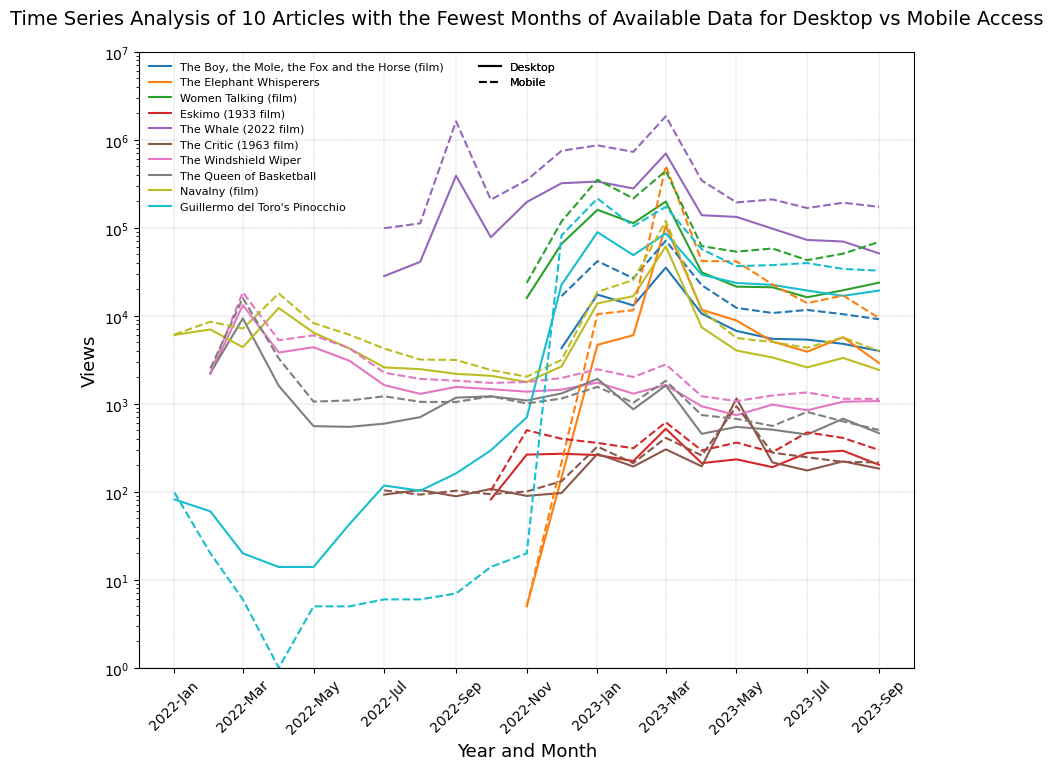

In [38]:
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

# Iterate through all the articles in desktop and mobile to plot the views as a timeseries graph
for desktop_article in desktop_fewest10:
    desktop_article_result = desktop_df[desktop_df['article']==desktop_article]
    ax.plot(desktop_article_result['timestamp'], desktop_article_result['views'], linestyle='-',
            label=desktop_article.replace('_',' '))
    
for mobile_article in mobile_fewest10:
    mobile_article_result = mobile_df[mobile_df['article']==mobile_article]
    ax.plot(mobile_article_result['timestamp'], mobile_article_result['views'], linestyle='--',
            label=mobile_article.replace('_',' '))

# Set the x-axis ticks to show alternate months in the data
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# Change the format of the x-axix label (prior to this it is 'YYYY-MM')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

# Set axes labels and title with appropriate font size
plt.xlabel('Year and Month', fontsize=13)
plt.ylabel('Views', fontsize=13)
plt.title('Time Series Analysis of 10 Articles with the Fewest Months of Available Data for Desktop vs Mobile \
Access', pad=20, fontsize=14)

# Since the total views largely vary in scale, use logarithmic axis to better portray the data
ax.set_yscale('log')
ax.set_ylim([1e0, 1e7])

# The first legend below represents all the article names
# Here, the legend is set to only the desktop movies since the movie list for both desktop and mobile access is
# exactly same. This helps save up some space on the plot!
legend1 = plt.legend(labels=[d.replace('_', ' ') for d in desktop_fewest10], loc='upper left', 
                     prop = {"size": 8}, frameon=False)
ax.add_artist(legend1)

# The second legend groups the titles based on the two access types - desktop and mobile
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend2 = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.55, 1), prop = {"size": 8}, 
                    frameon=False)
ax.add_artist(legend2)

# Add gridlines
plt.grid(True, linestyle='--', color='gray', linewidth=0.2)

plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()

From the final plot above, it can be inferred that each article follows a similar trend for both mobile and desktop views. Excluding a few exceptions, most of the articles follow a pattern where the mobile views are higher than the desktop views.

## 4. Conclusion

In conclusion, three graphs were built from the monthly article traffic data for articles about academy award winning movies from English Wikipedia from July 1, 2015 through September 30, 2023. The three plots built shed some light on the trends and patterns present in the underlying data. The first graph explored the time series relationship for the articles that had the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. It was found that the 'Joker (2019)' and 'The Whale (2022)' movies have the highest monthly average views for desktop and mobile access respectively. The 'Project Hope' movie on the other hand, had the lowest monthly average views for both desktop and mobile access. The second graph contained time series data for the top 10 article pages by largest page views over the entire time by access type. It was observed that the peaks for the mobile views were higher than that of desktop. All the peaks were also clustered into roughly four groups. The third graph showed pages that had the fewest months of available data across desktop and mobile access types. The line graphs were all relatively short time series and contained a set of the most recent academy award winners. It was inferred that each article followed a similar trend for both mobile and desktop views.